In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Visualizing outliers before removal...


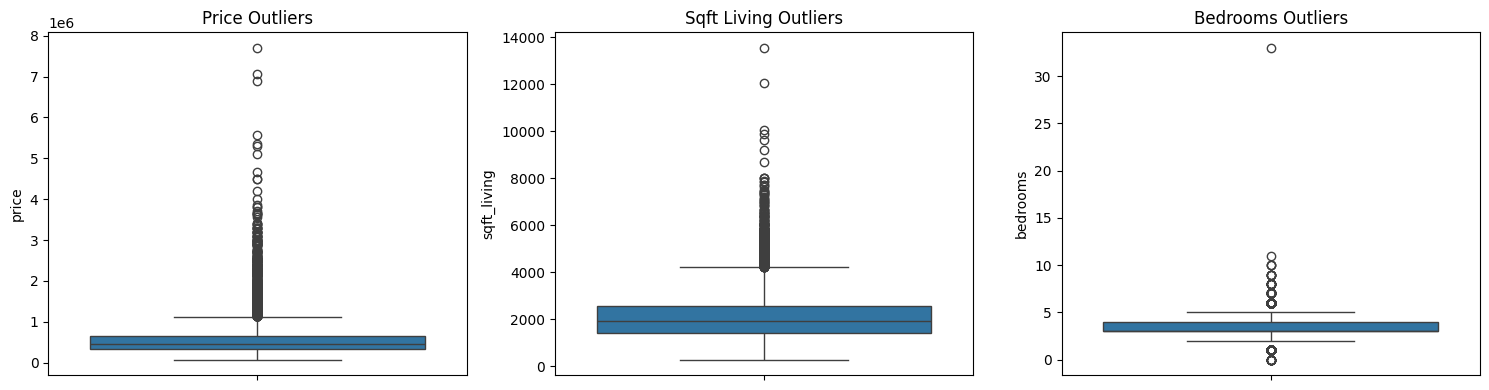

Shape of dataframe after removing outliers: (19687, 21)


In [ ]:

df = pd.read_csv("https://raw.githubusercontent.com/panchaldhruv27223/datasets_for_ml_-csv-xlsl-/refs/heads/main/kc_house_data.csv")


for col in ['sqft_lot', 'bathrooms']:
    df.loc[df.sample(frac=0.05, random_state=42).index, col] = np.nan

print("Visualizing outliers before removal...")
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['price'])
plt.title('Price Outliers')
plt.subplot(1, 3, 2)
sns.boxplot(y=df['sqft_living'])
plt.title('Sqft Living Outliers')
plt.subplot(1, 3, 3)
sns.boxplot(y=df['bedrooms'])
plt.title('Bedrooms Outliers')
plt.tight_layout()
plt.show()


for col in ['price', 'sqft_living', 'bedrooms']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"Shape of dataframe after removing outliers: {df.shape}")


df['date'] = pd.to_datetime(df['date'])


df['sale_year'] = df['date'].dt.year 
df['sale_month'] = df['date'].dt.month 
df['house_age'] = df['sale_year'] - df['yr_built'] 


df['was_renovated'] = df['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1) 
df['age_since_renovation'] = np.where(df['yr_renovated'] == 0, df['house_age'], df['sale_year'] - df['yr_renovated']) 


df['sqft_living_per_floor'] = df['sqft_living'] / df['floors'].replace(0, 1) 
df['bath_per_bed'] = df['bathrooms'] / df['bedrooms'].replace(0, 1) 


df.drop(['id', 'date', 'yr_built', 'yr_renovated'], axis=1, inplace=True)

In [ ]:

numerical_features = ['sqft_living', 'sqft_lot', 'bathrooms', 'sqft_above', 'sqft_basement',
                      'sqft_living15', 'sqft_lot15', 'house_age', 'age_since_renovation',
                      'sqft_living_per_floor', 'bath_per_bed', 'lat', 'long'] 

categorical_features = ['zipcode'] 

passthrough_features = ['bedrooms', 'floors', 'waterfront', 'view', 'condition',
                        'grade', 'sale_year', 'sale_month', 'was_renovated'] 


numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('pass', 'passthrough', passthrough_features)
    ])

In [ ]:

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42))])
param_grid_rf = {
    'regressor__n_estimators': [100, 200], 
    'regressor__max_depth': [10, 20] 
}


gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', GradientBoostingRegressor(random_state=42))])
param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1]
}


xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(random_state=42, eval_metric='rmse'))])
param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1]
}



print("\n--- Tuning Models (this may take a few minutes) ---")
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
print(f"Best Params for Random Forest: {grid_search_rf.best_params_}")
print(f"Best CV R² Score for RF: {grid_search_rf.best_score_:.4f}\n")

grid_search_gb = GridSearchCV(gb_pipeline, param_grid_gb, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train, y_train)
print(f"Best Params for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Best CV R² Score for GB: {grid_search_gb.best_score_:.4f}\n")

grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
print(f"Best Params for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best CV R² Score for XGB: {grid_search_xgb.best_score_:.4f}\n")


--- Tuning Models (this may take a few minutes) ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params for Random Forest: {'regressor__max_depth': 20, 'regressor__n_estimators': 200}
Best CV R² Score for RF: 0.8507

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params for Gradient Boosting: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best CV R² Score for GB: 0.8581

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best CV R² Score for XGB: 0.8737



--- Final Evaluation of Best Tuned Model (XGBoost) ---
R² Score on Test Set: 0.8783
Mean Absolute Error (MAE): $49,711.13
Root Mean Squared Error (RMSE): $71,345.37

--- Performance Comparison ---
Baseline (Untuned RF) RMSE: $75,780.87
Final Tuned Model RMSE:     $71,345.37
Improvement:                5.85%



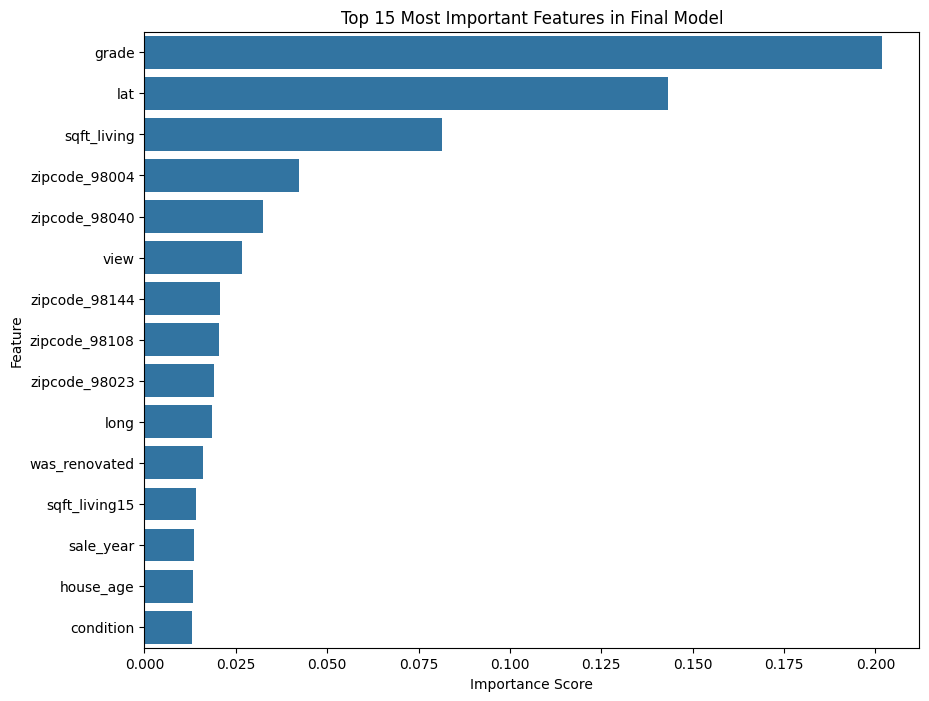

--- Analysis of Top 5 Features ---
          Feature  Importance
88          grade    0.201940
11            lat    0.143192
0     sqft_living    0.081459
16  zipcode_98004    0.042334
38  zipcode_98040    0.032576


In [ ]:
# --- Final Evaluation ---

best_model_pipeline = grid_search_xgb.best_estimator_ # XGBoost performs best

final_predictions = best_model_pipeline.predict(X_test)


final_r2 = r2_score(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions)) # [cite: 68]

print("--- Final Evaluation of Best Tuned Model (XGBoost) ---")
print(f"R² Score on Test Set: {final_r2:.4f}")
print(f"Mean Absolute Error (MAE): ${final_mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${final_rmse:,.2f}\n")


baseline_rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('regressor', RandomForestRegressor(random_state=42))])
baseline_rf_pipeline.fit(X_train, y_train)
baseline_predictions = baseline_rf_pipeline.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
improvement = ((baseline_rmse - final_rmse) / baseline_rmse) * 100 # 

print("--- Performance Comparison ---")
print(f"Baseline (Untuned RF) RMSE: ${baseline_rmse:,.2f}")
print(f"Final Tuned Model RMSE:     ${final_rmse:,.2f}")
print(f"Improvement:                {improvement:.2f}%\n")


cat_names = best_model_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_names) + passthrough_features

importances = best_model_pipeline.named_steps['regressor'].feature_importances_


importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances.
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Most Important Features in Final Model')
plt.xlabel('Importance Score')
plt.show()

# Analysis of the top 5 features.
print("--- Analysis of Top 5 Features ---")
print(importance_df.head(5))